Importa o modelo a ser fatiado e mapeado

In [1]:
import matplotlib.pyplot as plt
import gui
import files
from timer import Timer
from components.layer import Layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
choice = gui.ask_load_or_begin()
if choice == "Novo Projeto":
    path_input, file_name = gui.load_model(folders)
    [dpi, layer_height] = gui.ask_parameters_input()
    with Timer("Fase 0: "):
        Layer.create_layers(folders, path_input, file_name, dpi, layer_height)
elif choice == "Carregar Salvo":
    gui.find_saved_file(folders)
elif choice == "Cancelar":
    quit

#TODO: encontrar uma forma de jogar layerHight para o slicing W/images (POSSIVELMENTE COM O RUNSINGLEMODEL)

Fase 0: 
criando as camadas
First arg: /home/matheus/TangranV2/input/stl_models/conecomplicado90.stl
Second arg: 300.0
Script executed from: /home/matheus/TangranV2
Script executed from: /home/matheus/TangranV2/input/sliced
Script executed from: /home/matheus/TangranV2
Script executed from: /home/matheus/TangranV2/slicing-with-images
number of degenerated triangles = 0
eps = 0.004
max thickness = 2
rounded plane spacing spacing = 2
model zmin = -25, model zmax = 100, first plane Z = -26.996, number of planes = 65
-Incremental, conecomplicado90.stl, thickness = 2, #T = 1140, #P = 63, #S = 11177, 0.001743s (slicing), 0.006546s (polygon assembling), 0.02435s (total), *K: 9.80439


/bin/bash: /home/matheus/anaconda3/lib/python3.11/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
rm: cannot remove '*.svg': No such file or directory
rm: cannot remove '*.png': No such file or directory




writing image: ../input/sliced/layer_000.pgm


writing image: ../input/sliced/layer_001.pgm


writing image: ../input/sliced/layer_002.pgm


writing image: ../input/sliced/layer_003.pgm


writing image: ../input/sliced/layer_004.pgm


writing image: ../input/sliced/layer_005.pgm


writing image: ../input/sliced/layer_006.pgm


writing image: ../input/sliced/layer_007.pgm


writing image: ../input/sliced/layer_008.pgm


writing image: ../input/sliced/layer_009.pgm


writing image: ../input/sliced/layer_010.pgm


writing image: ../input/sliced/layer_011.pgm


writing image: ../input/sliced/layer_012.pgm


writing image: ../input/sliced/layer_013.pgm


writing image: ../input/sliced/layer_014.pgm


writing image: ../input/sliced/layer_015.pgm


writing image: ../input/sliced/layer_016.pgm


writing image: ../input/sliced/layer_017.pgm


writing image: ../input/sliced/layer_018.pgm


writing image: ../input/sliced/layer_019.pgm


writing image: ../input/sliced/layer_020.pgm


writing ima

Paredes Finas

In [2]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
#[nozzle_diam_internal,nozzle_diam_external] = gui.ask_parameters_thin_walls()
[d_ext, sob_ext_per] = gui.ask_parameters_thin_walls()
camadas = folders.load_layers_hdf5()
for i,c in enumerate(camadas):
    with Timer("Fase 1: Camada: " + str(i)):
        folders.load_islands_hdf5(c)
        #c.make_thin_walls(folders, nozzle_diam_external, nozzle_diam_internal)
        c.make_thin_walls(folders, d_ext, sob_ext_per)
        %reset_selective -f "c"
%reset_selective -f "camadas"
# TODO: arvore de paredes finas
# TODO: quando duas áreas se encontram
# TODO: limite de parede diam minimo
# TODO arrumar para origens extremamente pequenas, ignorar da problema
# TODO arrumar casos onde a beirada esta vazndo criando areas triangulares distantes
# FIXME: Precisa mesmo separar linha 1 2 topo e baixo? muitos elementos estão sendo criados

Fase 1: Camada: 0
Criando paredes finas
Total de [Criando paredes finas] : 0.8678154945373535
Retirando Paredes finas da camada
Total de [Retirando Paredes finas da camada] : 0.00032210350036621094
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.01737809181213379
Total de [Fase 1: Camada: 0] : 0.922429084777832
Fase 1: Camada: 1
Criando paredes finas
Total de [Criando paredes finas] : 0.8615002632141113
Retirando Paredes finas da camada
Total de [Retirando Paredes finas da camada] : 0.0002803802490234375
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.011442422866821289
Total de [Fase 1: Camada: 1] : 0.8969495296478271
Fase 1: Camada: 2
Criando paredes finas
Total de [Criando paredes finas] : 0.8410210609436035
Retirando Paredes finas da camada
Total de [Retirando Paredes finas da camada] : 0.0018489360809326172
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.01719069480895996
Total de [Fase 1: Camada: 2] : 0.89

Contornos

In [3]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[void_max,external_max,internal_max] = gui.ask_parameters_offsets()
camadas = folders.load_layers_hdf5()
for i,c in enumerate(camadas):
    with Timer("Fase 2: Camada: " + str(i)):
        folders.load_islands_hdf5(c)
        c.make_offsets(folders, void_max, external_max, internal_max)
        folders.save_props_hdf5(f"/{c.name}",c.__dict__)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 2: Camada: 0
Criando Lvls
Ilha: I_000 Número de Níveis: 2
Total de [Criando Lvls] : 0.3056485652923584
Criando os loops
Total de [Criando os loops] : 0.12085199356079102
Criando regiões de influência
Total de [Criando regiões de influência] : 0.009856700897216797
Criando as regiões de Offset
Total de [Criando as regiões de Offset] : 0.05359244346618652
Retirando regiões da camada
['Lvl_000', 0, 0] Perdendo total:32 maior void:0.003329633740288568Bw -> aceito
['Lvl_001', 0, 0] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_000', 1, 0] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_001', 1, 0] Perdendo total:0 maior void:0Bw -> aceito
Total de [Retirando regiões da camada] : 0.14295697212219238
Reunindo todos os loops em uma unica imagem
Total de [Reunindo todos os loops em uma unica imagem] : 0.011946916580200195
salvando imagens das regiões
deletado: /L_000/I_000/offsets
Total de [salvando imagens das regiões] : 0.08067440986633301
Total de [Fase 2: Camada: 0] : 0.75573945045471

Pontes

In [1]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd
import numpy as np
from components import images_tools as it

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[n_max, d_int, sob_int_per] = gui.ask_parameters_bridges()
camadas = folders.load_layers_hdf5()
last_prohibited_areas = np.zeros(camadas[0].base_frame)
for i,c in enumerate(camadas):
    with Timer("Fase 3: Camada: " + str(i)):
        if i%2 == 1:
            last_image = it.rotate_img_cw(last_prohibited_areas )
        elif i%2 == 0:
            last_image = it.rotate_img_ccw(last_prohibited_areas )
        if i >= 2:
            if i%2 == 1:
                second_last_image = it.rotate_img_cw(camadas[i - 1].prohibited_areas)
            elif i%2 == 0:
                second_last_image = it.rotate_img_ccw(camadas[i - 1].prohibited_areas)
        else:
            second_last_image = np.zeros_like(last_image)
        c.prohibited_areas = last_image
        sum_prohibited_areas = it.sum_imgs([last_image, second_last_image])
        last_prohibited_areas = c.make_bridges(folders, n_max, d_int, sob_int_per, len(camadas), sum_prohibited_areas)
        folders.save_props_hdf5(f"/{c.name}",c.__dict__)
%reset_selective -f "camadas"

Fase 3: Camada: 0
Value(False)
Criando pontes de Offset
Total de [Criando pontes de Offset] : 0.49219632148742676
Criando pontes de Zigzag
Fechou uma ponte OK
Total de [Criando pontes de Zigzag] : 19.19143271446228
Criando pontes de Crossover
Elemento: ('Reg_000', 'Reg_001') Maior prioridade: 0
Total de [Criando pontes de Crossover] : 0.010661602020263672
Retirando pontes da Camada
Total de [Retirando pontes da Camada] : 0.009411096572875977
Gerando áreas proibidas
Total de [Gerando áreas proibidas] : 0.0001380443572998047
salvando imagens das regiões
deletado: /L_000/I_000/bridges
Total de [salvando imagens das regiões] : 0.08755040168762207
Total de [Fase 3: Camada: 0] : 23.62636947631836
Fase 3: Camada: 1
Criando pontes de Offset
Total de [Criando pontes de Offset] : 0.505014181137085
Criando pontes de Zigzag
Fechou uma ponte OK
Total de [Criando pontes de Zigzag] : 3.885770559310913
Criando pontes de Crossover
Elemento: ('Reg_000', 'Reg_001') Maior prioridade: 0
Total de [Criando p

Zigzags

In [2]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5() 
for i, c in enumerate(camadas):
    with Timer("Fase 4: Camada: " + str(i)):
        c.make_zigzags(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"


Fase 4: Camada: 0
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 1.3053181171417236
salvando imagens das regiões
deletado: /L_000/I_000/zigzags
Total de [salvando imagens das regiões] : 0.004109859466552734
Total de [Fase 4: Camada: 0] : 1.356431484222412
Fase 4: Camada: 1
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 3.244811773300171
salvando imagens das regiões
deletado: /L_001/I_000/zigzags
Total de [salvando imagens das regiões] : 0.0032639503479003906
Total de [Fase 4: Camada: 1] : 3.2947261333465576
Fase 4: Camada: 2
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 3.144388437271118
salvando imagens das regiões
deletado: /L_002/I_000/zigzags
Total de [salvando imagens das regiões] : 0.003637075424194336
Total de [Fase 4: Camada: 2] : 3.1904757022857666
Fase 4: Camada: 3
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 1.660200595855713
salvando imagens das regiões
deletado: /L_00

iMAGEM DO MAPEAMENTO

Fase 4: Camada: 0


Total de [Fase 4: Camada: 0] : 0.21040654182434082
Fase 4: Camada: 1


Total de [Fase 4: Camada: 1] : 0.17387771606445312
Fase 4: Camada: 2


Total de [Fase 4: Camada: 2] : 0.164046049118042
Fase 4: Camada: 3


Total de [Fase 4: Camada: 3] : 0.28885555267333984
Fase 4: Camada: 4


Total de [Fase 4: Camada: 4] : 0.16440105438232422
Fase 4: Camada: 5


Total de [Fase 4: Camada: 5] : 0.16803312301635742
Fase 4: Camada: 6


Total de [Fase 4: Camada: 6] : 0.15602946281433105
Fase 4: Camada: 7


Total de [Fase 4: Camada: 7] : 0.15267014503479004
Fase 4: Camada: 8


Total de [Fase 4: Camada: 8] : 0.15417909622192383
Fase 4: Camada: 9


Total de [Fase 4: Camada: 9] : 0.16478610038757324
Fase 4: Camada: 10


Total de [Fase 4: Camada: 10] : 0.16190028190612793
Fase 4: Camada: 11


Total de [Fase 4: Camada: 11] : 0.164808988571167
Fase 4: Camada: 12


Total de [Fase 4: Camada: 12] : 0.16095232963562012
Fase 4: Camada: 13


Total de [Fase 4: Camada: 13] : 0.16717267036437988
Fa

/tmp/ipykernel_36202/2409409764.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()




Total de [Fase 4: Camada: 21] : 0.16970133781433105
Fase 4: Camada: 22


Total de [Fase 4: Camada: 22] : 0.15670323371887207
Fase 4: Camada: 23


Total de [Fase 4: Camada: 23] : 0.17300176620483398
Fase 4: Camada: 24


Total de [Fase 4: Camada: 24] : 0.16803765296936035
Fase 4: Camada: 25


Total de [Fase 4: Camada: 25] : 0.1634378433227539
Fase 4: Camada: 26


Total de [Fase 4: Camada: 26] : 0.31061434745788574
Fase 4: Camada: 27


Total de [Fase 4: Camada: 27] : 0.16547131538391113
Fase 4: Camada: 28


Total de [Fase 4: Camada: 28] : 0.1665053367614746
Fase 4: Camada: 29


Total de [Fase 4: Camada: 29] : 0.15902924537658691
Fase 4: Camada: 30


Total de [Fase 4: Camada: 30] : 0.16333770751953125
Fase 4: Camada: 31


Total de [Fase 4: Camada: 31] : 0.1655263900756836
Fase 4: Camada: 32


Total de [Fase 4: Camada: 32] : 0.16533946990966797
Fase 4: Camada: 33


Total de [Fase 4: Camada: 33] : 0.16079998016357422
Fase 4: Camada: 34


Total de [Fase 4: Camada: 34] : 0.1671438217163086
F

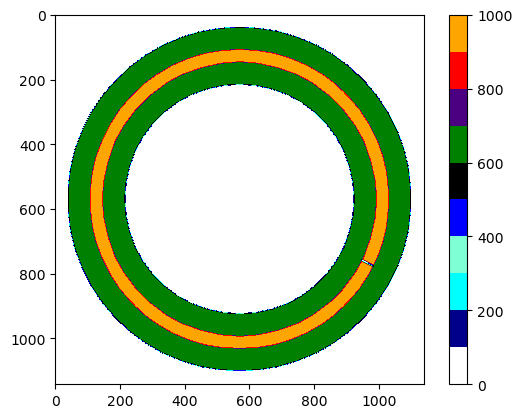

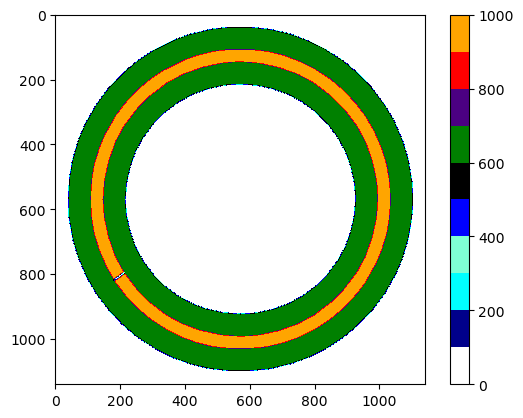

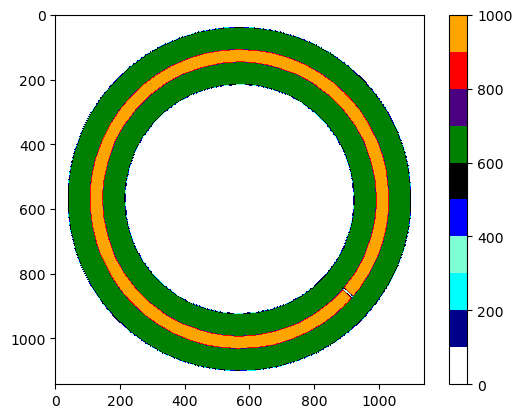

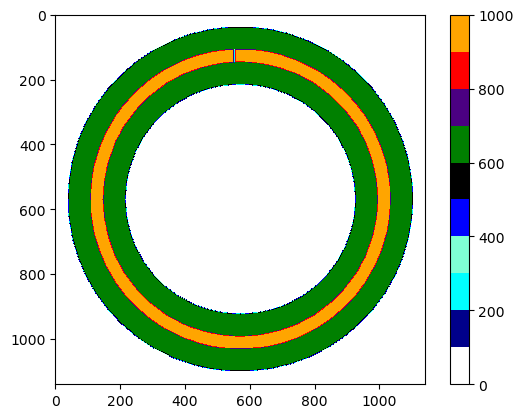

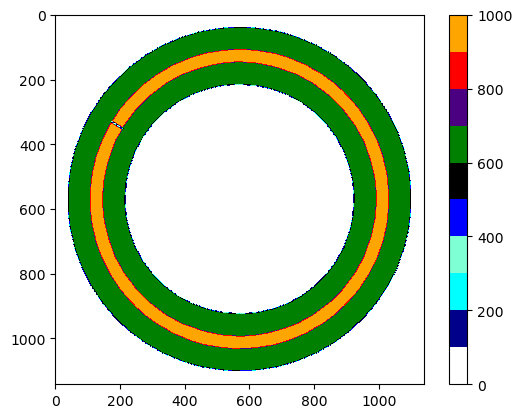

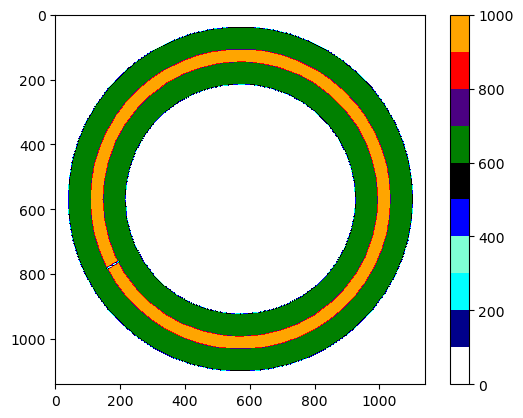

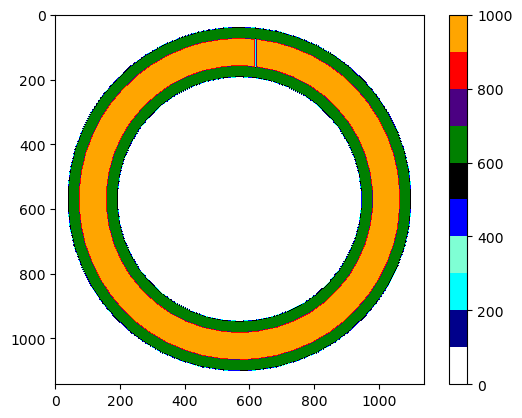

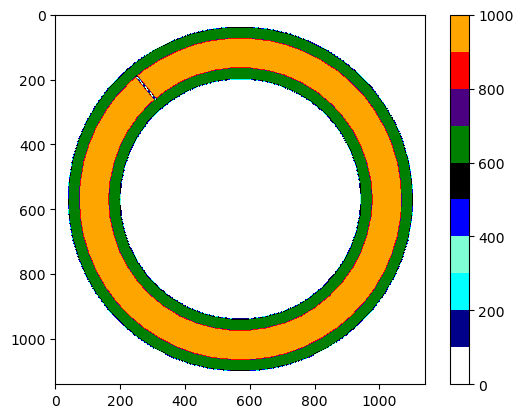

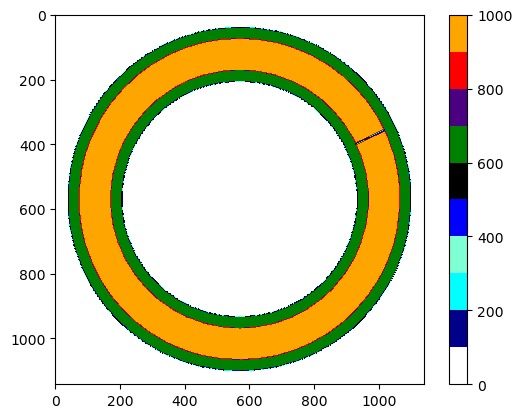

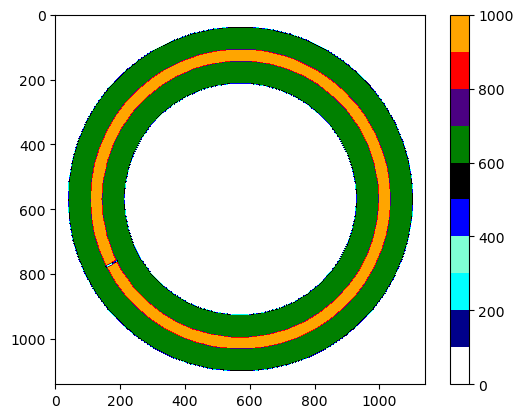

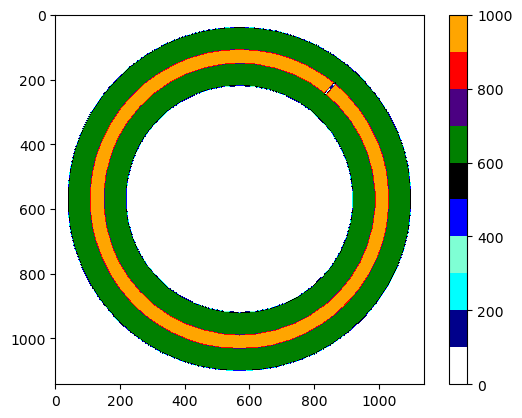

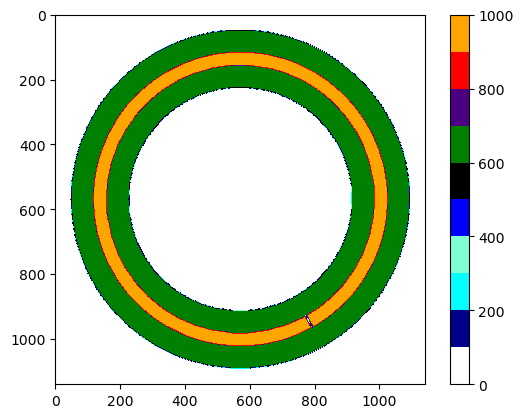

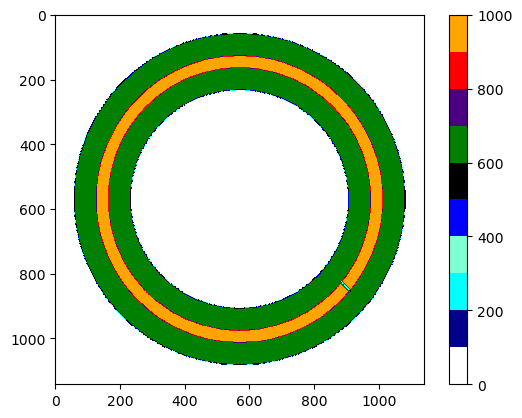

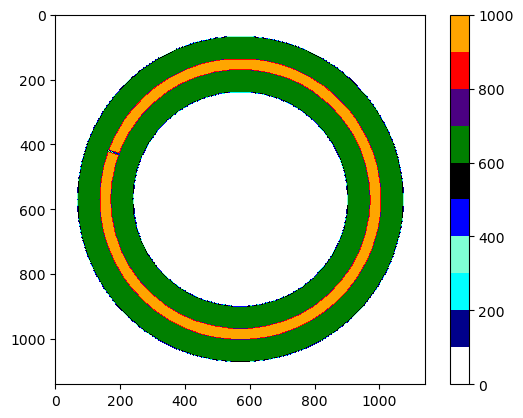

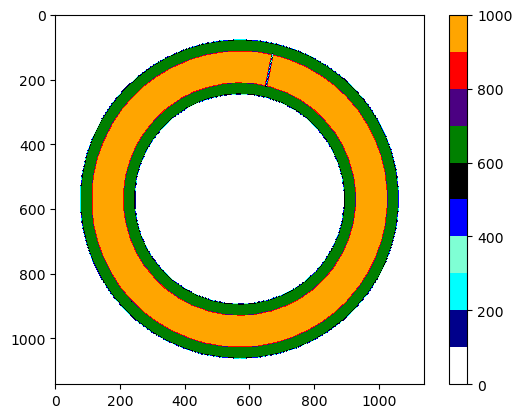

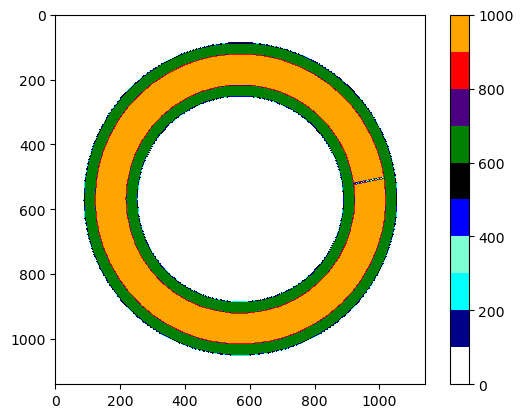

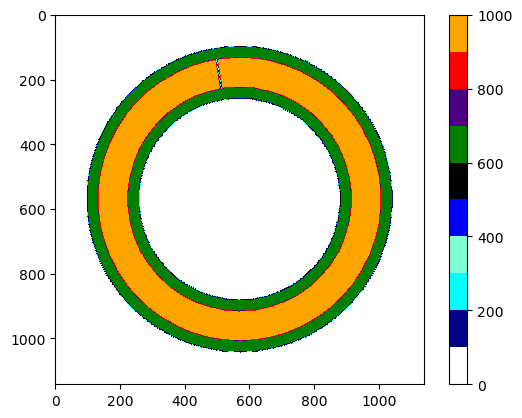

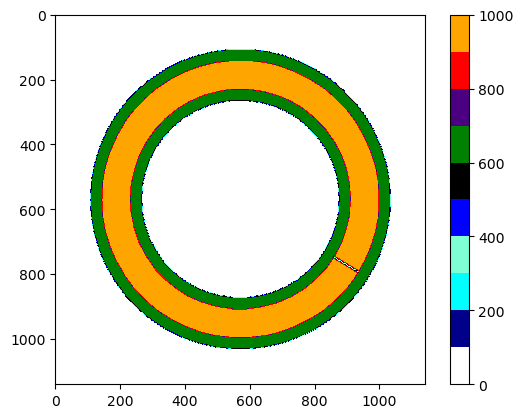

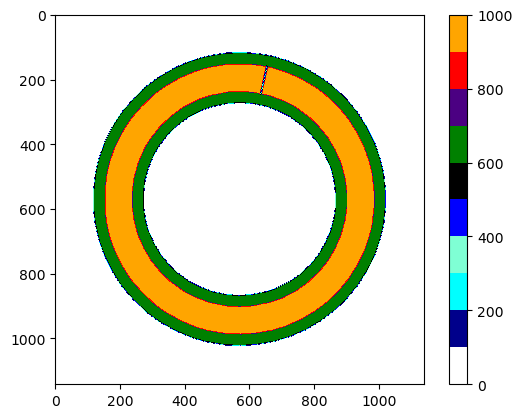

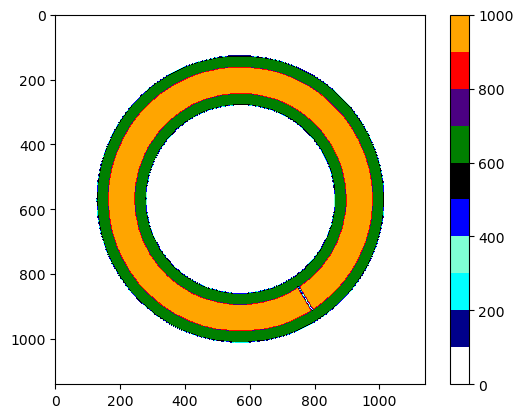

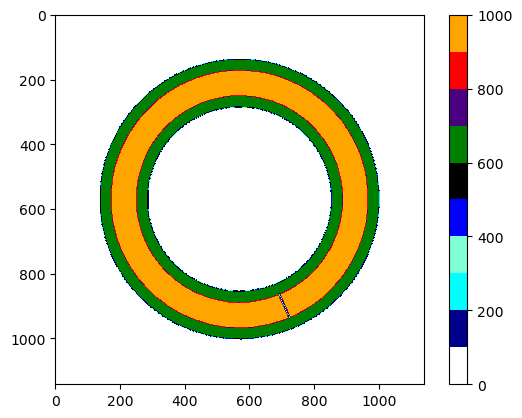

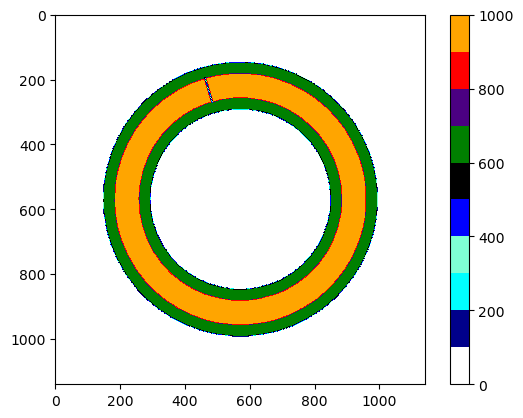

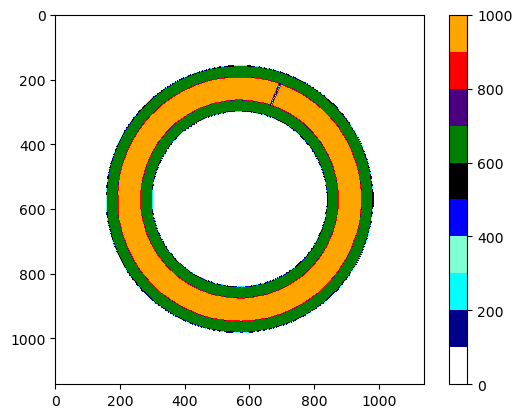

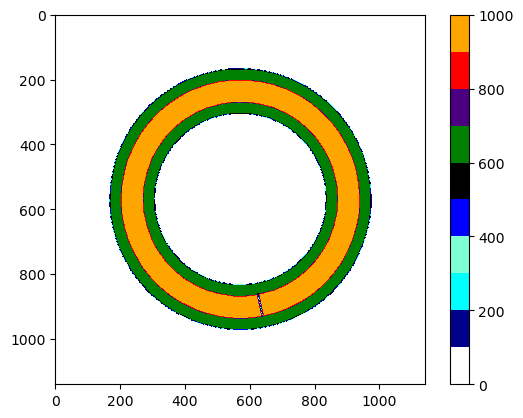

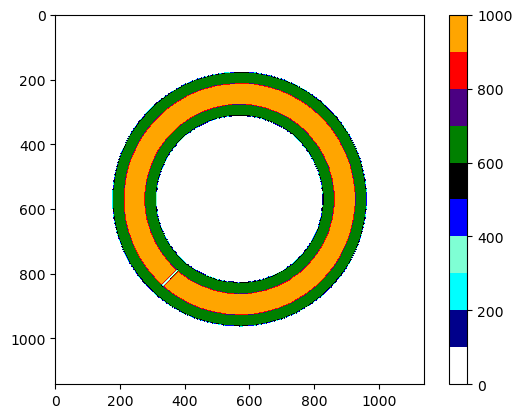

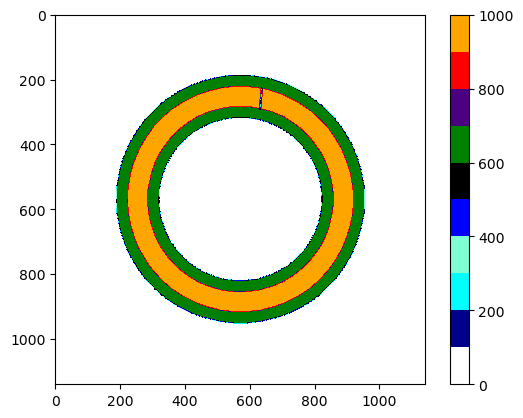

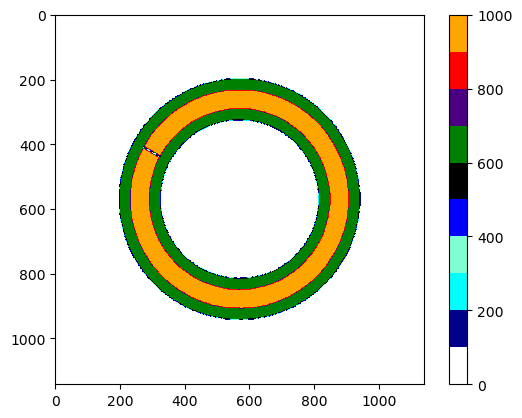

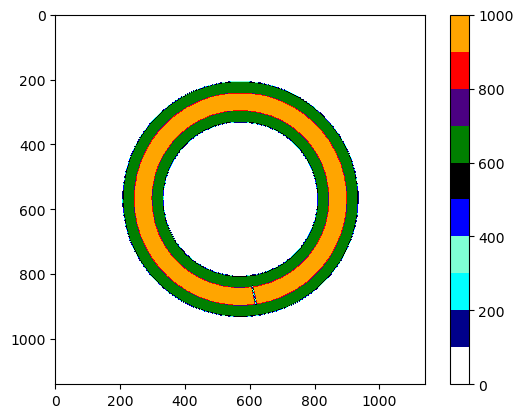

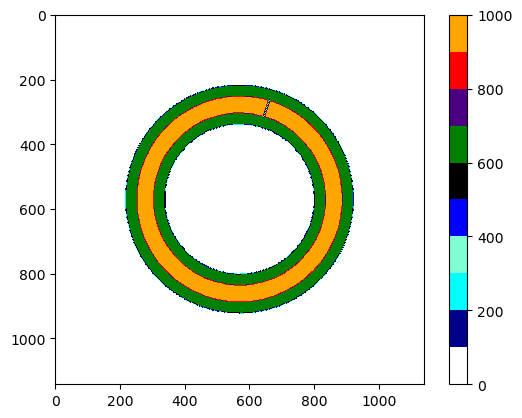

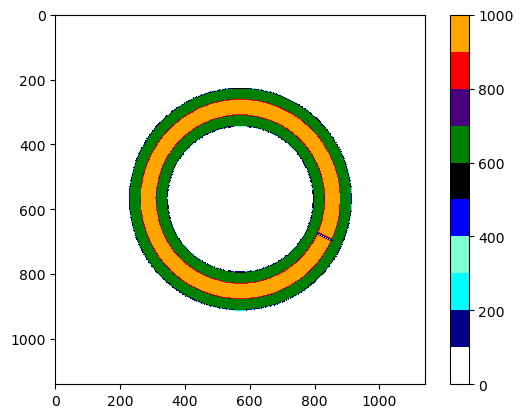

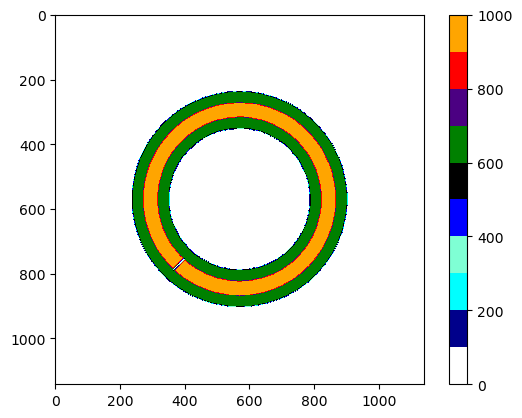

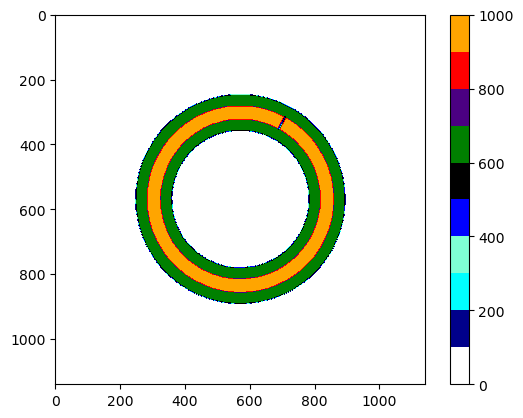

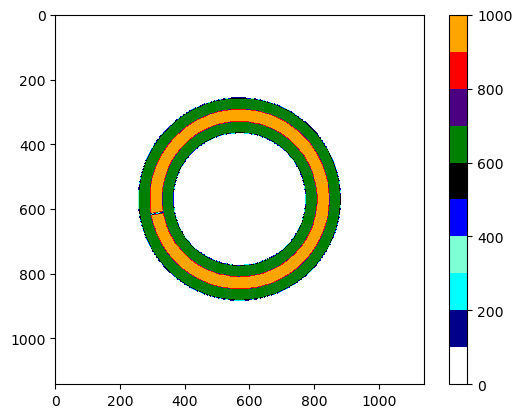

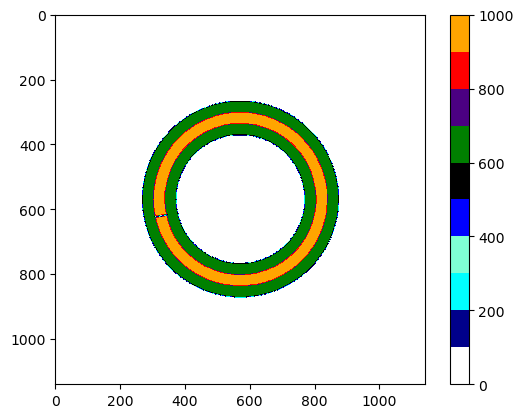

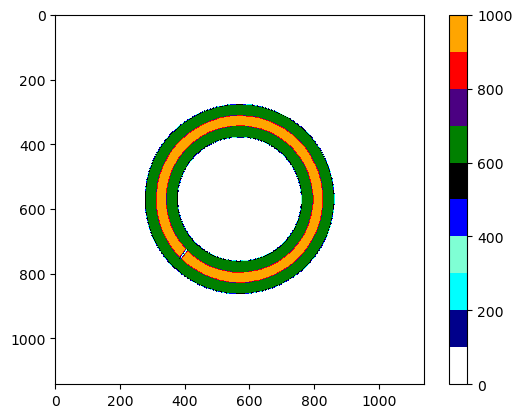

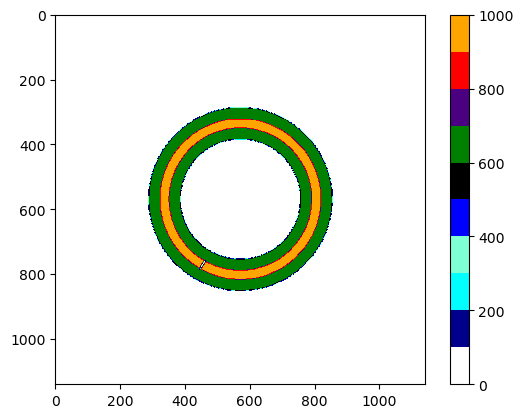

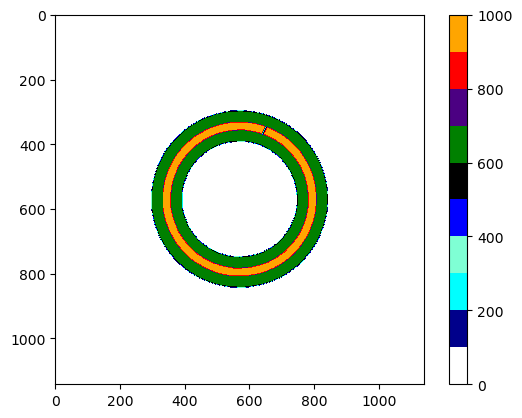

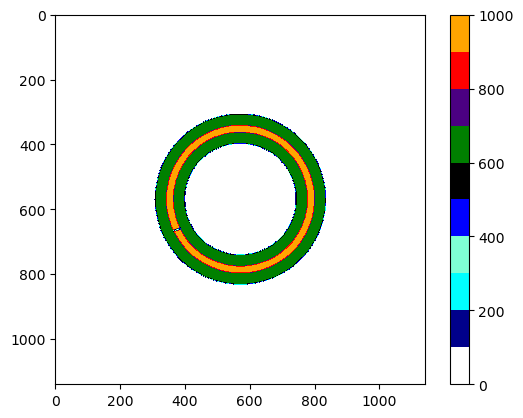

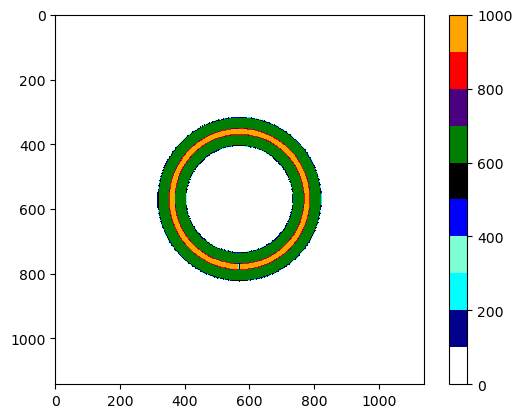

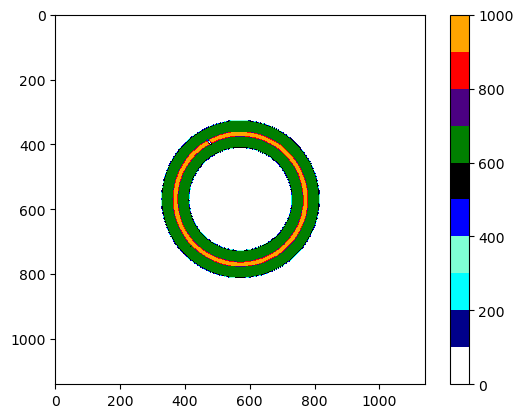

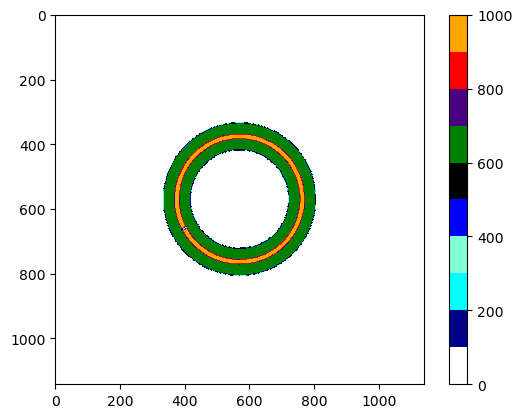

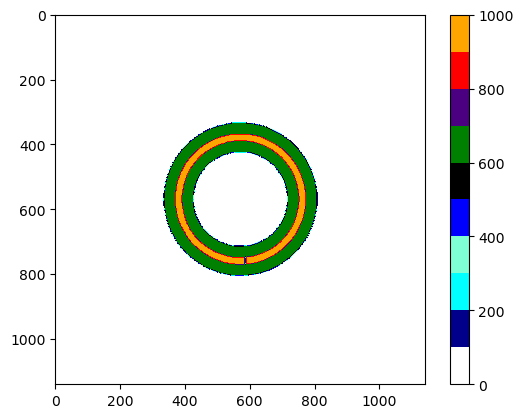

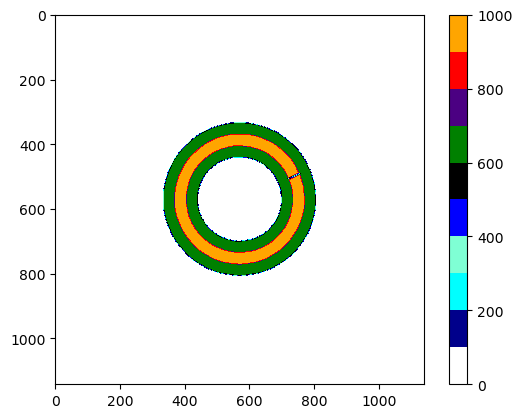

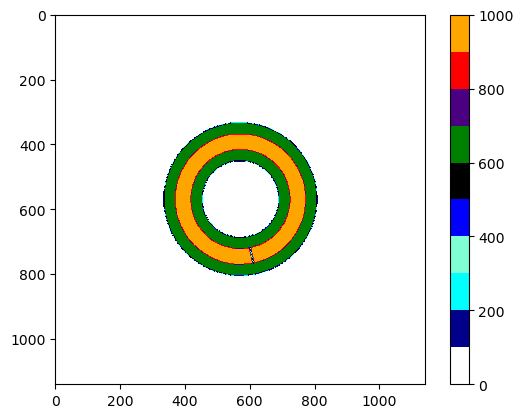

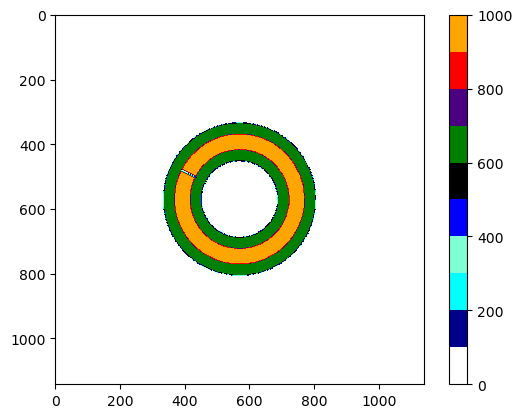

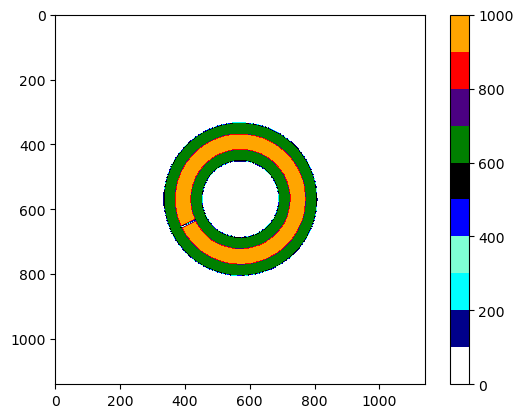

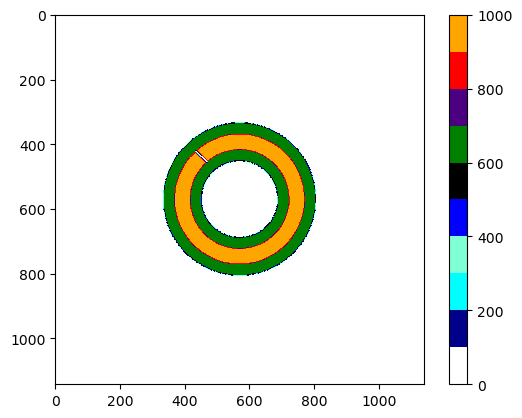

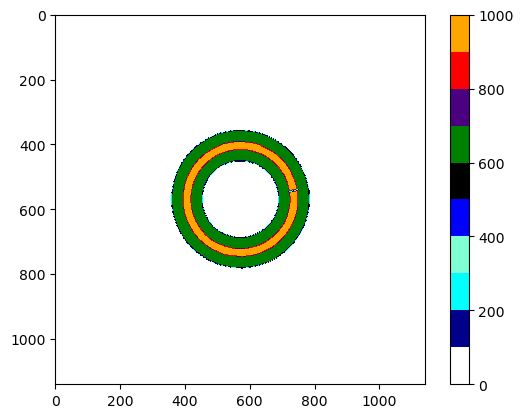

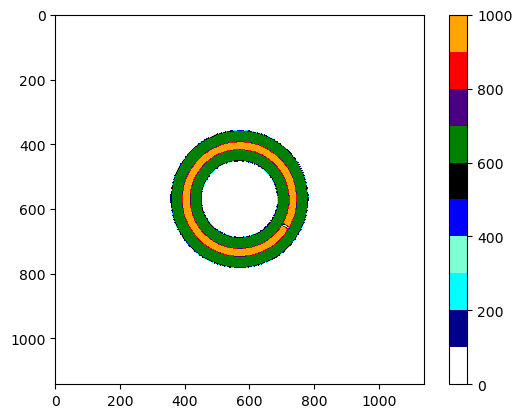

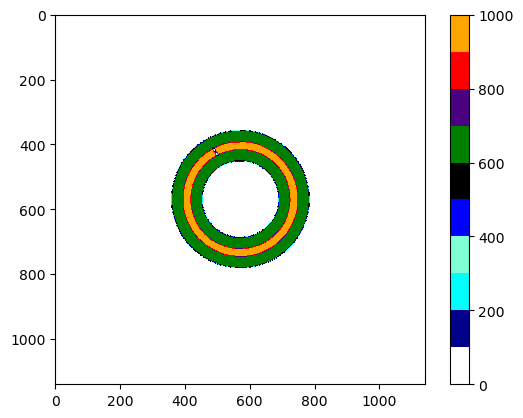

In [3]:
import gui
import files
from timer import Timer
from components import images_tools as it
from os import getcwd
import matplotlib.pyplot as plt
import matplotlib.colors
import os

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5() 
for c in camadas:
    folders.load_islands_hdf5(c)
tangran_cmap = matplotlib.colors.ListedColormap(["white","darkblue","aqua","aquamarine","blue","black","green","indigo","red","orange"])
for i, c in enumerate(camadas):
    with Timer("Fase 4: Camada: " + str(i)):
        plt.figure()
        img_mapping = it.final_mapping(c, folders)
        plt.imshow(img_mapping, cmap=tangran_cmap, vmin=0, vmax=1000)
        plt.imsave("aaa.png",img_mapping, cmap=tangran_cmap, vmin=0, vmax=1000)
        plt.colorbar()
        print('\n')

ROTAS

Rotas de Offset

In [4]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

amendment_size = 0.7 #porcentagem do tamanho da poca de deposicao de material
for c in camadas:
    with Timer("Making offset routes"):
        c.make_offset_routes(amendment_size, folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.03188037872314453
Total de [Making offset routes] : 0.9414663314819336
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.03226184844970703
Total de [Making offset routes] : 0.8663151264190674
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.0311279296875
Total de [Making offset routes] : 0.9116213321685791
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.03295254707336426
Total de [Making offset routes] : 0.7288646697998047
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.042583465576171875
Total de [Making offset routes] : 0.9327385425567627
Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.03364276885986328
Total de [Making offset routes] : 0.8672780990600586
Making offset routes
salvando imagens

Rotas de pontes

In [5]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
[sob_int_ext_per] = gui.ask_parameters_internal_routes()

with Timer(f"Making bridges routes"):
    for c in camadas:
        with Timer(f"Camada: {c.name}"):
            c.make_bridges_routes(folders, sob_int_ext_per)
            %reset_selective -f "c"
%reset_selective -f "camadas"

Making bridges routes
Camada: L_000
Making Offset bridges routes
Total de [Making Offset bridges routes] : 0.0002262592315673828
Making Zigzag bridges routes
Total de [Making Zigzag bridges routes] : 6.842613220214844e-05
Making Crossover bridges routes
Total de [Making Crossover bridges routes] : 7.655768871307373
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.03635144233703613
Total de [Camada: L_000] : 7.786902904510498
Camada: L_001
Making Offset bridges routes
Total de [Making Offset bridges routes] : 0.000118255615234375
Making Zigzag bridges routes
Total de [Making Zigzag bridges routes] : 3.743171691894531e-05
Making Crossover bridges routes
Total de [Making Crossover bridges routes] : 7.267456531524658
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.04171490669250488
Total de [Camada: L_001] : 7.396221399307251
Camada: L_002
Making Offset bridges routes
Total de [Making Offset bridges routes] : 0.00014925003051757812
Making Zigzag bri

Rotas de Ziguezague

In [6]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Making zigzag routes"):
        c.make_zigzag_routes(folders)
        c.connect_zigzags(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"



Making zigzag routes
criando as rotas de zigzag, camada:L_000
Total de [criando as rotas de zigzag, camada:L_000] : 0.0004856586456298828
salvando imagens das rotas
deletado: /L_000/I_000/zigzags
Total de [salvando imagens das rotas] : 0.002763509750366211
Criando os grafos de regiões
Total de [Criando os grafos de regiões] : 0.0018820762634277344
Conectando regiões de zigzag
Total de [Conectando regiões de zigzag] : 0.0013768672943115234
salvando grafos
Total de [salvando grafos] : 0.043228864669799805
Total de [Making zigzag routes] : 0.11748337745666504
Making zigzag routes
criando as rotas de zigzag, camada:L_001
Total de [criando as rotas de zigzag, camada:L_001] : 0.00038504600524902344
salvando imagens das rotas
deletado: /L_001/I_000/zigzags
Total de [salvando imagens das rotas] : 0.002579212188720703
Criando os grafos de regiões
Total de [Criando os grafos de regiões] : 0.002062082290649414
Conectando regiões de zigzag
Total de [Conectando regiões de zigzag] : 0.00143551826477

WEAVING

In [7]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
[iwflag] = gui.ask_parameters_weaving()
for c in camadas:
    with Timer("Fase 5 b"):
        c.internal_weaving(iwflag, folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 5 b
gerando preenchimentos oscilatórios
Total de [gerando preenchimentos oscilatórios] : 0.539076566696167
salvando rotas
deletado: /L_000/I_000/zigzags/macro_areas
Total de [salvando rotas] : 0.04590034484863281
Total de [Fase 5 b] : 0.5854134559631348
Fase 5 b
gerando preenchimentos oscilatórios
Total de [gerando preenchimentos oscilatórios] : 0.5501701831817627
salvando rotas
deletado: /L_001/I_000/zigzags/macro_areas
Total de [salvando rotas] : 0.04629921913146973
Total de [Fase 5 b] : 0.59678053855896
Fase 5 b
gerando preenchimentos oscilatórios
Total de [gerando preenchimentos oscilatórios] : 0.5502364635467529
salvando rotas
deletado: /L_002/I_000/zigzags/macro_areas
Total de [salvando rotas] : 0.04613614082336426
Total de [Fase 5 b] : 0.5967085361480713
Fase 5 b
gerando preenchimentos oscilatórios
Total de [gerando preenchimentos oscilatórios] : 0.5111236572265625
salvando rotas
deletado: /L_003/I_000/zigzags/macro_areas
Total de [salvando rotas] : 0.04571127891540527
Tota

Total de [gerando preenchimentos oscilatórios] : 0.7077300548553467
salvando rotas
deletado: /L_049/I_000/zigzags/macro_areas
Total de [salvando rotas] : 0.048041582107543945
Total de [Fase 5 b] : 0.7561469078063965


Rotas de Thin Walls

In [8]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Fase 5"):
        with Timer("Making thin walls routes"):
            c.make_thin_wall_routes(folders)
            %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 5
Making thin walls routes
criando rotas TW
Total de [criando rotas TW] : 0.02262139320373535
salvando imagens das rotas
Total de [salvando imagens das rotas] : 6.198883056640625e-06
Total de [Making thin walls routes] : 0.022892236709594727
Total de [Fase 5] : 0.023005247116088867
Fase 5
Making thin walls routes
criando rotas TW
Total de [criando rotas TW] : 0.0195462703704834
salvando imagens das rotas
Total de [salvando imagens das rotas] : 6.4373016357421875e-06
Total de [Making thin walls routes] : 0.019835710525512695
Total de [Fase 5] : 0.01985621452331543
Fase 5
Making thin walls routes
criando rotas TW
Total de [criando rotas TW] : 0.02420520782470703
salvando imagens das rotas
Total de [salvando imagens das rotas] : 6.198883056640625e-06
Total de [Making thin walls routes] : 0.024451255798339844
Total de [Fase 5] : 0.02446746826171875
Fase 5
Making thin walls routes
criando rotas TW
Total de [criando rotas TW] : 0.021415233612060547
salvando imagens das rotas
Total de [s

Encontrando o lugar onde será o começo da trilha de cada ilha

In [9]:
import gui
import files
from timer import Timer
from components import layer, path_tools
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    c.islands_path_starts(folders)

%reset_selective -f "camadas"                        

Encontrando ponto de união ext-int
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.0010707378387451172
Total de [Encontrando ponto de união ext-int] : 0.0097198486328125
Encontrando ponto de união ext-int
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.0010793209075927734
Total de [Encontrando ponto de união ext-int] : 0.008067131042480469
Encontrando ponto de união ext-int
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.0010573863983154297
Total de [Encontrando ponto de união ext-int] : 0.008572578430175781
Encontrando ponto de união ext-int
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.0011010169982910156
Total de [Encontrando ponto de união ext-int] : 0.00820302963256836
Encontrando ponto de união ext-int
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.001108407974243164
Total de [Encontrando ponto de união ext-int] : 0.008238554000854492
Encontrando ponto de união ext-int
salv

Unificando rotas EXTERNAS nas camadas

In [1]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer(f"Fase 6: layer_{c.name}"):
        c.close_routes_external(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"
    

Fase 6: layer_L_000
Conectando rotas externas
Conectando pontes de Offset
Total de [Conectando pontes de Offset] : 0.09829926490783691
Conectando pontes de Crossover
salto:  [763, 927]
Total de [Conectando pontes de Crossover] : 0.5979433059692383
Total de [Conectando rotas externas] : 0.8405771255493164
salvando imagens das rotas
deletado: /L_000/I_000/external_tree_route
Total de [salvando imagens das rotas] : 0.06374645233154297
Total de [Fase 6: layer_L_000] : 0.9046640396118164
Fase 6: layer_L_001
Conectando rotas externas
Conectando pontes de Offset
Total de [Conectando pontes de Offset] : 0.08253669738769531
Conectando pontes de Crossover
salto:  [779, 223]
Total de [Conectando pontes de Crossover] : 0.5856044292449951
Total de [Conectando rotas externas] : 0.8075289726257324
salvando imagens das rotas
deletado: /L_001/I_000/external_tree_route
Total de [salvando imagens das rotas] : 0.06286811828613281
Total de [Fase 6: layer_L_001] : 0.8705854415893555
Fase 6: layer_L_002
Cone

Unificando rotas INTERNAS nas camadas

In [2]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer(f"Fase 7: Layer_{c.name}"):
        c.close_routes_internal(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 7: Layer_L_000
Conectando zgzags vizinhos
Total de [Conectando zgzags vizinhos] : 0.0001575946807861328
rotas internas inexistentes
salvando imagens das rotas
deletado: /L_000/I_000/internal_tree_route
Total de [salvando imagens das rotas] : 0.006002187728881836
Total de [Fase 7: Layer_L_000] : 0.15495848655700684
Fase 7: Layer_L_001
Conectando zgzags vizinhos
Total de [Conectando zgzags vizinhos] : 0.00048279762268066406
rotas internas inexistentes
salvando imagens das rotas
deletado: /L_001/I_000/internal_tree_route
Total de [salvando imagens das rotas] : 0.004240989685058594
Total de [Fase 7: Layer_L_001] : 0.15906453132629395
Fase 7: Layer_L_002
Conectando zgzags vizinhos
Total de [Conectando zgzags vizinhos] : 0.00014591217041015625
rotas internas inexistentes
salvando imagens das rotas
deletado: /L_002/I_000/internal_tree_route
Total de [salvando imagens das rotas] : 0.004994392395019531
Total de [Fase 7: Layer_L_002] : 0.15502429008483887
Fase 7: Layer_L_003
Conectando zgza

Unindo rotas de thin walls

In [3]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer(f"Fase 8: Layer_{c.name}"):
        c.close_routes_thinwalls(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 8: Layer_L_000
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.00012254714965820312
salvando imagens das rotas
deletado: /L_000/I_000/thinwalls_tree_route/sequence
deletado: /L_000/I_000/thinwalls_tree_route/saltos
Total de [salvando imagens das rotas] : 0.047980546951293945
Total de [Fase 8: Layer_L_000] : 0.07167220115661621
Fase 8: Layer_L_001
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.0002684593200683594
salvando imagens das rotas
deletado: /L_001/I_000/thinwalls_tree_route/sequence
deletado: /L_001/I_000/thinwalls_tree_route/saltos
Total de [salvando imagens das rotas] : 0.04809880256652832
Total de [Fase 8: Layer_L_001] : 0.06599760055541992
Fase 8: Layer_L_002
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.0002002716064453125
salvando imagens das rotas
deletado: /L_002/I_000/thinwalls_tree_route/sequence
deletado: /L_002/I_000/thinwalls_tree_route/saltos
Total de [salvando imagens das rotas] : 0.0481803417205810

Unindo todas as rotas

In [4]:
import gui
import files
from timer import Timer
from components import layer, path_tools
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    c.close_final_path(folders)

%reset_selective -f "camadas"


Encontrando ponto de união ext-int
Total de [Encontrando ponto de união ext-int] : 8.916854858398438e-05
Conectando todas as partes
Total de [Conectando todas as partes] : 0.014920949935913086
salvando imagens das rotas
deletado: /L_000/I_000/island_route
[[785, 1000], [813, 986], [857, 957], [895, 925], [942, 877], [975, 832], [1002, 785], [1024, 732], [1040, 678], [1048, 628], [1050, 591], [1048, 512], [1039, 457], [1024, 408], [1007, 367], [972, 304], [941, 262], [895, 215], [861, 186], [816, 156], [760, 128], [706, 108], [654, 96], [610, 91], [533, 91], [489, 96], [425, 112], [383, 128], [327, 156], [286, 183], [248, 215], [201, 263], [170, 305], [143, 351], [118, 409], [103, 458], [95, 505], [91, 556], [91, 586], [94, 628], [103, 683], [118, 732], [143, 790], [167, 832], [201, 878], [247, 925], [281, 954], [331, 987], [383, 1013], [432, 1031], [483, 1043], [541, 1049], [559, 1049], [561, 1051], [561, 1081], [559, 1083], [541, 1083], [480, 1077], [424, 1064], [371, 1045], [310, 101

Gerando o Código G

In [2]:
import gui
import files
from timer import Timer
from components import layer, path_tools
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[vel_int, vel_ext, vel_thin_wall, vel_vazio, p_religamento, p_desligamento, p_entre_int_ext, p_entre_camadas, substratoy, substratox, cortey, cortex] = gui.ask_parameters_Gcode()
coords_substrato = [substratoy, substratox]
coords_corte = [cortey, cortex]
camadas = folders.load_layers_hdf5()

#layer_heights = [10+2.9+3+(i*1.5) for i,x in enumerate(camadas)]
layer_heights = [35+8+2+(i*1.5) for i,x in enumerate(camadas)]
with Timer("Cuspindo o Gcode"):
    path_tools.layers_to_Gcode(camadas, 
                               folders, 
                               vel_int,
                               vel_ext, 
                               vel_vazio,
                               vel_thin_wall, 
                               p_religamento,
                               p_desligamento,
                               p_entre_int_ext,
                               p_entre_camadas,
                               layer_heights,
                               coords_substrato,
                               coords_corte,
                               )
%reset_selective -f "camadas"

Cuspindo o Gcode
nome: L_000/I_000
[[1041, 849], [445, 849], [444, 848], [427, 848], [426, 847], [392, 846], [391, 845], [386, 845], [385, 844], [381, 844], [380, 843], [376, 843], [375, 842], [371, 842], [370, 841], [366, 841], [365, 840], [360, 840], [359, 839], [345, 837], [344, 836], [336, 834], [333, 832], [325, 830], [323, 828], [317, 827], [316, 826], [311, 825], [308, 823], [300, 821], [248, 795], [227, 781], [224, 778], [211, 770], [200, 760], [199, 760], [165, 728], [165, 727], [159, 721], [159, 720], [153, 714], [153, 713], [147, 707], [147, 706], [141, 700], [141, 699], [134, 691], [124, 676], [123, 673], [109, 653], [97, 629], [97, 627], [86, 606], [86, 604], [85, 603], [85, 601], [84, 600], [84, 598], [83, 597], [83, 595], [82, 594], [82, 592], [81, 591], [81, 589], [80, 588], [80, 586], [79, 585], [79, 583], [78, 582], [78, 580], [70, 558], [70, 555], [69, 554], [69, 550], [68, 549], [68, 545], [67, 544], [67, 539], [66, 538], [66, 534], [65, 533], [65, 529], [64, 528], 

In [6]:
# import numpy as np
# camadas = folders.load_layers_hdf5()
# for c in camadas:
#     folders.load_islands_hdf5(c)
#     for isl in c.islands:
#         folders.load_island_paths_hdf5(c.name, isl)
#         internal_trees = [list(x) for x in isl.internal_tree_route.sequence]
#         print(internal_trees)
# print([235,807] in internal_trees)

In [7]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np

# # Lista de imagens binárias (exemplo com arrays numpy)
# imagens = [
#     img_mapping,
#     img_mapping,
#     img_mapping
# ]

# # Lista de alturas no eixo z
# alturas = [0, 10, 20]

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# for img, z in zip(imagens, alturas):
#     x = np.linspace(0, img.shape[1], img.shape[1])
#     y = np.linspace(0, img.shape[0], img.shape[0])
#     x, y = np.meshgrid(x, y)
#     z = np.full_like(x, z)
#     ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=plt.cm.gray(img), shade=False)

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# plt.show()


In [8]:
# import gui
# import files
# from timer import Timer
# from components import layer, path_tools
# from os import getcwd

# if not('folders' in globals()):
#     home = getcwd()
#     folders = files.System_Paths(home)
#     gui.find_saved_file(folders)
# camadas = folders.load_layers_hdf5()

# file_name = gui.find_saved_file(folders)
# path_tools.layers_to_Gcode_FFF(camadas, folders, file_name)

In [9]:
# class TrafficLightState:
#     """Base class for traffic light states."""
#     def change(self, traffic_light):
#         raise NotImplementedError("This method should be overridden by subclasses")


# class RedState(TrafficLightState):
#     """State representing the red light."""
#     def change(self, traffic_light):
#         print("Changing from Red to Green")
#         traffic_light.state = GreenState()


# class YellowState(TrafficLightState):
#     """State representing the yellow light."""
#     def change(self, traffic_light):
#         print("Changing from Yellow to Red")
#         traffic_light.state = RedState()


# class GreenState(TrafficLightState):
#     """State representing the green light."""
#     def change(self, traffic_light):
#         print("Changing from Green to Yellow")
#         traffic_light.state = YellowState()


# class TrafficLight:
#     """Traffic light class that uses a state machine."""
#     def __init__(self):
#         self.state = RedState()  # Initial state

#     def change(self):
#         """Change the state of the traffic light."""
#         self.state.change(self)

#     def __str__(self):
#         return f"Current state: {self.state.__class__.__name__}"


# # Example usage
# if __name__ == "__main__":
#     traffic_light = TrafficLight()
    
#     # Simulate the traffic light changing states
#     for _ in range(6):  # Change state 6 times
#         print(traffic_light)
#         traffic_light.change()

In [10]:
# import numpy as np
# import cv2  # Assuming you are using OpenCV for image processing

# def bobobo(image1, image2):
#     """A placeholder function that performs some operation on two images."""
#     # For demonstration, let's just return the absolute difference between the two images
#     return cv2.absdiff(image1, image2)

# def process_images(image_list):
#     """Process a list of images, comparing the last two with the current image."""
#     for i in range(len(image_list)):
#         current_image = image_list[i]
        
#         # Check if there are at least two previous images to compare
#         if i >= 2:
#             last_image = image_list[i - 1]
#             second_last_image = image_list[i - 2]
            
#             # Apply the bobobo function to the current image and the last two images
#             result_last = bobobo(current_image, last_image)
#             result_second_last = bobobo(current_image, second_last_image)
            
#             # Here you can do something with the results, like saving or displaying them
#             # For demonstration, we'll just print the shapes of the results
#             print(f"Comparing image {i} with last image {i-1}: result shape = {result_last.shape}")
#             print(f"Comparing image {i} with second last image {i-2}: result shape = {result_second_last.shape}")

# # Example usage
# if __name__ == "__main__":
#     # Create a list of dummy images (for demonstration purposes)
#     # In practice, you would load your images using cv2.imread or similar
#     image_list = [np.random.randint(0, 256, (100, 100, 3), dtype=np.uint8) for _ in range(5)]
    
#     process_images(image_list)